In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

## Open MNIST data and create a subset with desired digits
MNIST dataset contains 70,000 images of hand-written digits from 0 to 9. Each image has a grey-scale resolution of 28 $\times$ 28 (i.e., 784 pixels). Each pixel has an integer value ranging from 0 (bright) to 255 (dark).

<font color=red>Change the code below to select a different subset </font>

In [3]:
# I picked classes 2 and 3 instead of 0 and 1 as indicated 
# in the above instructions, but the instructions on the 
# icon pdf for this project say to use 0 and 1.

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

# Change the conditions below to compare between other two digits.
class1Indices = (y==2)
class2Indices = (y==3)

x1 = X[class1Indices]
x2 = X[class2Indices]


#TESTING ONLY

# Count the number of images for digits 2 and 3
number_of_class1_images = np.sum(class1Indices)
number_of_class2_images = np.sum(class2Indices)

# Total images of digits 2 and 3
total_images_2_and_3 = number_of_class1_images + number_of_class2_images

# Calculate the number of test images as 30% of the total images of digits 2 and 3
test_set_proportion = 0.3
number_of_test_images = int(total_images_2_and_3 * test_set_proportion)

# Print out the number of test images
print(number_of_test_images)


##################################

Xtrain = np.concatenate((x1,x2),axis=0)
ytrain = np.concatenate((np.zeros(x1.shape[0]),np.ones(x2.shape[0])),axis=0)

# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)



c:\Users\maxfi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


4239


# Split the data to training, testing, and validation subsets

In [4]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)
    
# Split the data to training, testing, and validation subsets
    
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2/3, random_state=1) # 0.25 x 0.8 = 0.2


Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]


# Accuracy of a classifier

In [5]:
# Function to test classifier accuracy
def testLinearClassifier(a, X, y):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]  # add bias term
    predictions = X_b.dot(a)
    predictions = (predictions > 0).astype(int)
    misclassifications = np.sum(predictions != y.reshape(-1, 1))
    return misclassifications

def calculate_percent_error(misclassifications, total_samples):
    return (misclassifications / total_samples) * 100

def transform_samples_using_eigenvectors(X, U, mean):
    # Subtract the mean from each sample
    X_centered = X - mean

    # Project onto the eigenvectors
    X_transformed = np.dot(X_centered, U.T)
    return X_transformed

## Define and test gaussianClassifierWithIdentityCovariance 

Training percent error rate: 6.824385805277525%
Validation percent error rate: 6.960873521383075%
Test percent error rate: 6.721698113207547%


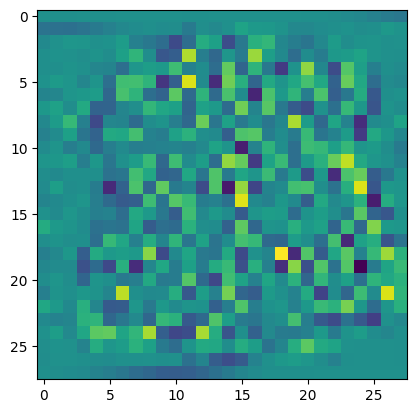

In [6]:
#------TRAINING CODE --------------

# Gaussian Classifier with Identity Covariance
def gaussianClassifierWithIdentityCovariance(Xtrain, ytrain):
    mean1 = np.mean(Xtrain[ytrain == 0], axis=0)
    mean2 = np.mean(Xtrain[ytrain == 1], axis=0)
    a = np.insert(mean2 - mean1, 0, 0).reshape(-1, 1)  # inserting bias term
    return a


#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------

# Compute the covariance matrix and its eigen decomposition
mean = np.mean(X_train, axis=0)
cov_matrix = np.cov(X_train.T)
eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)

# Apply the transformation to the training, validation, and test datasets
X_train_transformed = transform_samples_using_eigenvectors(X_train, eigen_vectors, mean)
X_val_transformed = transform_samples_using_eigenvectors(X_val, eigen_vectors, mean)
X_test_transformed = transform_samples_using_eigenvectors(X_test, eigen_vectors, mean)

a = gaussianClassifierWithIdentityCovariance(X_train_transformed, y_train)
plt.imshow(np.reshape(a[0:784],(28,28)))

# Test the classifier on PCA-transformed data
train = testLinearClassifier(a, X_train_transformed, y_train)
val = testLinearClassifier(a, X_val_transformed, y_val)
test = testLinearClassifier(a, X_test_transformed, y_test)

# Calculate and print the percent error rates
train_error_rate = calculate_percent_error(train, len(X_train))
val_error_rate = calculate_percent_error(val, len(X_val))
test_error_rate = calculate_percent_error(test, len(X_test))

print(f"Training percent error rate: {train_error_rate}%")
print(f"Validation percent error rate: {val_error_rate}%")
print(f"Test percent error rate: {test_error_rate}%")



## Define and test gaussianClassifierWithCommonCovariance 

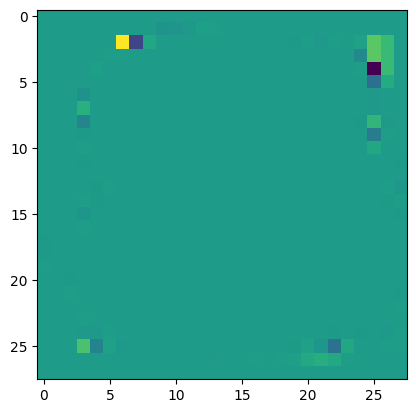

In [7]:
#------TRAINING CODE --------------

# Gaussian Classifier with Common Covariance
def gaussianClassifierWithCommonCovariance(Xtrain, ytrain, reg_lambda=1e-4):
    mean1 = np.mean(Xtrain[ytrain == 0], axis=0)
    mean2 = np.mean(Xtrain[ytrain == 1], axis=0)
    covariance = np.cov(Xtrain.T)
    
    # Regularization to avoid singular matrix
    covariance += np.eye(covariance.shape[0]) * reg_lambda
    
    covariance_inv = np.linalg.inv(covariance)
    a = np.insert(covariance_inv.dot(mean2 - mean1), 0, 0).reshape(-1, 1)  # inserting bias term
    return a
    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = gaussianClassifierWithCommonCovariance(X_train,y_train)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)


## Define and test logisticRegression 

You may choose the step size as 1e-4. You can try changing it.

Use the expit() function from scipy.special.expit to implement sigmoid without overflow errors 

Training percent error rate: 1.6681831968456171%
Validation percent error rate: 3.002729754322111%
Test percent error rate: 3.9150943396226414%


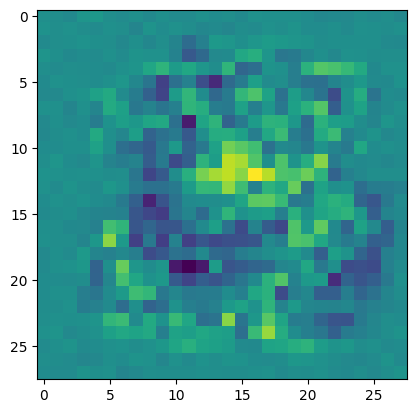

In [8]:
# Logistic Regression
def logisticRegression(Xtrain, ytrain, iterations, step_size, verbose=False):
    a = 0.01 * np.random.randn(Nfeatures + 1, 1)
    X_b = np.c_[np.ones((Xtrain.shape[0], 1)), Xtrain]  # add bias term
    
    for _ in range(iterations):
        predictions = expit(X_b.dot(a))
        gradient = X_b.T.dot(predictions - ytrain.reshape(-1, 1))
        a -= step_size * gradient
    
    return a

#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = logisticRegression(X_train,y_train,iterations=500,step_size=1e-6, verbose=False)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)

# Total samples in each dataset
total_train_samples = len(X_train)
total_val_samples = len(X_val)
total_test_samples = len(X_test)

# Calculate percent error rate for each dataset
train_error_rate = calculate_percent_error(train, total_train_samples)
val_error_rate = calculate_percent_error(val, total_val_samples)
test_error_rate = calculate_percent_error(test, total_test_samples)

# Print the error rates
print(f"Training percent error rate: {train_error_rate}%")
print(f"Validation percent error rate: {val_error_rate}%")
print(f"Test percent error rate: {test_error_rate}%")



Training misclassifications: 77
Validation misclassifications: 204
Test misclassifications: 147
Training percent error rate: 2.335456475583864%
Validation percent error rate: 3.0937215650591448%
Test percent error rate: 3.4669811320754715%


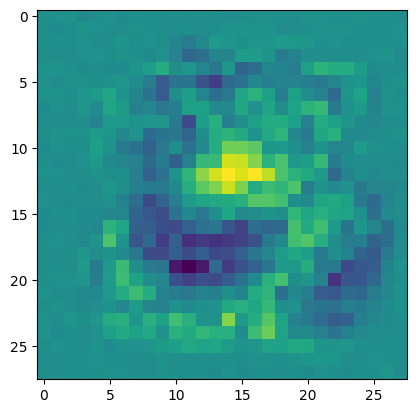

In [9]:
# Logistic Regression with Regularization
def logisticRegressionWithRegularization(Xtrain, ytrain, iterations=100, step_size=1e-6, lam=0, verbose=False):
    a = 0.01 * np.random.randn(Nfeatures + 1, 1)
    X_b = np.c_[np.ones((Xtrain.shape[0], 1)), Xtrain]  # add bias term
    
    for _ in range(iterations):
        predictions = expit(X_b.dot(a))
        gradient = X_b.T.dot(predictions - ytrain.reshape(-1, 1)) + lam * np.vstack([np.zeros((1, 1)), a[1:]])
        a -= step_size * gradient
    
    return a

    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
# Function to calculate the percent error rate




a = logisticRegressionWithRegularization(X_train,y_train,iterations=500,verbose=False,lam=1)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)

# Total samples in each dataset
total_train_samples = len(X_train)
total_val_samples = len(X_val)
total_test_samples = len(X_test)


print(f"Training misclassifications: {train}")
print(f"Validation misclassifications: {val}")
print(f"Test misclassifications: {test}")

# Calculate percent error rate for each dataset
train_error_rate = calculate_percent_error(train, total_train_samples)
val_error_rate = calculate_percent_error(val, total_val_samples)
test_error_rate = calculate_percent_error(test, total_test_samples)

# Print the error rates
print(f"Training percent error rate: {train_error_rate}%")
print(f"Validation percent error rate: {val_error_rate}%")
print(f"Test percent error rate: {test_error_rate}%")



In [10]:
# Function to optimize hyperparameters
def optimizeHyperparameters(Xtrain, ytrain, Xval, yval):
    best_lambda = 0
    min_misclassifications = float('inf')
    
    for lam in np.logspace(-4, 4, 100):
        a = logisticRegressionWithRegularization(Xtrain, ytrain, iterations=500, lam=lam)
        misclassifications = testLinearClassifier(a, Xval, yval)
        if misclassifications < min_misclassifications:
            min_misclassifications = misclassifications
            best_lambda = lam
    print("Best Lambda: ", best_lambda)
    return logisticRegressionWithRegularization(Xtrain, ytrain, iterations=500, lam=best_lambda)

# Optimize hyperparameters and get the model trained with the best lambda
a_best = optimizeHyperparameters(X_train, y_train, X_val, y_val)

# Testing
total_test_samples = len(X_test)
test_misclassifications = testLinearClassifier(a_best, X_test, y_test)
test_error_rate = (test_misclassifications / total_test_samples) * 100

print("Test percent error rate: ", test_error_rate, "%")


Best Lambda:  739.072203352579
Test percent error rate:  3.985849056603773 %


# REPORT TEST ERRORS OF THE BEST MODELS

YOUR CODE BELOW

In [11]:
# Training and evaluating classifiers on the new subset
a1 = gaussianClassifierWithIdentityCovariance(X_train, y_train)
a2 = gaussianClassifierWithCommonCovariance(X_train, y_train, reg_lambda=1e-4)
a3 = logisticRegression(X_train, y_train, iterations=500, step_size=1e-6)
a4 = optimizeHyperparameters(X_train, y_train, X_val, y_val)

# Testing classifiers on the new subset ((missclassifications))
train1 = testLinearClassifier(a1, X_test, y_test)
train2 = testLinearClassifier(a2, X_test, y_test)
train3 = testLinearClassifier(a3, X_test, y_test)
train4 = testLinearClassifier(a4, X_test, y_test)

# Displaying results for the new subset (2, 3)
error_rate_identity = (train1 / number_of_test_images) * 100
error_rate_common = (train2 / number_of_test_images) * 100
error_rate_logistic = (train3 / number_of_test_images) * 100
error_rate_regularized = (train4 / number_of_test_images) * 100

print("Identity Covariance Gaussian Classifier Error Rate:", error_rate_identity)
print("Common Covariance Gaussian Classifier Error Rate:", error_rate_common)
print("Logistic Regression Error Rate:", error_rate_logistic)
print("Regularized Logistic Regression Error Rate:", error_rate_regularized)


# Tests: 
# Identity Covariance Gaussian Classifier | Learning Rate:  Iterations:
# Common Covariance Gaussian Classifier | Learning Rate: 1e-4  Iterations:
# Logistic Regression | Learning Rate:  Iterations:
# Regularized Logistic Regression | Learning Rate:  Iterations:
#
#
# outputs

# 1. Best Lambda:  0.03199267137797385
# Identity Covariance Gaussian Classifier Error Rate: 6.770464732248172
# Common Covariance Gaussian Classifier Error Rate: 4.411417787213965
# Logistic Regression Error Rate: 3.8688369898560984
# Regularized Logistic Regression Error Rate: 3.0903514979948103




Best Lambda:  0.026560877829466867
Identity Covariance Gaussian Classifier Error Rate: 6.676102854446804
Common Covariance Gaussian Classifier Error Rate: 5.2842651568766215
Logistic Regression Error Rate: 3.821656050955414
Regularized Logistic Regression Error Rate: 3.845246520405756
